In [4]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

# Fetch dataset

In [3]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset, extract_triu

#dim ethen
dim = 26

def load_triu(S, P, dim):
    
    return [extract_triu(s, dim) for s in S], [extract_triu(p, dim) for p in P]

dataset, molecules = make_butadien_dataset(
    np.load("../data/molecules.npy"),
    np.load("../data/S.npy"), 
    np.load("../data/P.npy")
)

[-] 2018-05-28 17:28:02: Data set normalized. Mean value std: 0.008732722987069362


# Fetch network 

In [4]:
from SCFInitialGuess.nn.networks import EluFixedValue

graph = tf.Graph()

structure, weights, biases = np.load("../data/network.npy", encoding="latin1")

with graph.as_default():
    sess = tf.Session()
    network = EluFixedValue(structure, weights, biases)
    network.setup()
    sess.run(tf.global_variables_initializer())

# Create guesses

In [2]:
from SCFInitialGuess.utilities.dataset import make_matrix_batch
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny
from pyscf.scf import hf

s_raw = make_matrix_batch(dataset.inverse_input_transform(dataset.testing[0]), dim, False)

p_nn = network.run(sess, dataset.testing[0])

p_batch = make_matrix_batch(p_nn, dim, False)
p_mcw1 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=1), zip(p_batch, s_raw))))
p_mcw5 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=5), zip  (p_batch, s_raw))))

p_sap = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
])
p_minao = np.array([
    hf.init_guess_by_minao(mol.get_pyscf_molecule()) for mol in molecules[1]
])
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
])

NameError: name 'dataset' is not defined

(50, 26, 26)

# Measure iterations 

In [1]:
from SCFInitialGuess.utilities.analysis import measure_iterations, mf_initializer

iterations = []

# nn
iterations.append(measure_iterations(mf_initializer, p_batch, molecules[1]))
iterations.append(measure_iterations(mf_initializer, p_mcw1, molecules[1]))
iterations.append(measure_iterations(mf_initializer, p_mcw5, molecules[1]))
iterations.append(measure_iterations(mf_initializer, p_sap, molecules[1]))
iterations.append(measure_iterations(mf_initializer, p_minao, molecules[1]))
iterations.append(measure_iterations(mf_initializer, p_gwh, molecules[1]))

iterations = np.array(iterations).T
iterations.shape

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


NameError: name 'p_batch' is not defined

# Plot 

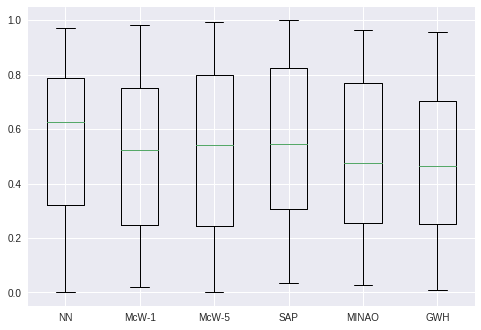

In [11]:
labels = ["NN", "McW-1", "McW-5", "SAP", "MINAO", "GWH"]

iterations = np.random.rand(100, 6)

plt.boxplot(iterations)
plt.xticks(np.arange(1, 7), labels)
plt.show()

# Subplot

[Text(0,0,'NN'),
 Text(0,0,'McW-1'),
 Text(0,0,'McW-5'),
 Text(0,0,'SAP'),
 Text(0,0,'MINAO'),
 Text(0,0,'GWH')]

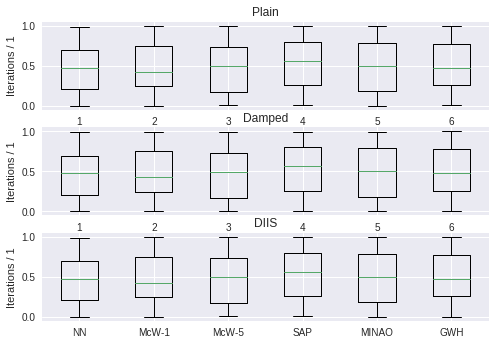

In [15]:
def add_plot(ax, title, data):
    
    ax.boxplot(data)
    ax.set_title(title)
    ax.set_ylabel("Iterations / 1")
    
    
    
data = np.random.rand(100, 6)
    
fig, axes = plt.subplots(3, 1)
titles = ["Plain", "Damped", "DIIS"]
for i in range(len(axes)):
    add_plot(axes[i], titles[i], data)
    
axes[-1].set_xticklabels(labels)

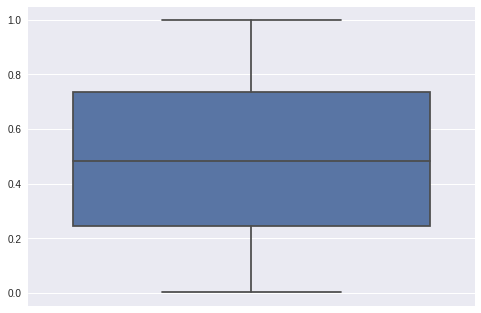

In [33]:
import seaborn as sns


data = np.random.rand(100, 6)
"""
data={
        "NN": iterations[:,0],
        "McW-1": iterations[:,1],
        "McW-5": iterations[:,2]
    }
#"""

sns.boxplot(
    list(data.T),
    orient="v"
)

plt.show()

In [32]:
list(data.T)

[array([0.71823409, 0.56231579, 0.40239712, 0.57033188, 0.70307495,
        0.02452326, 0.8634054 , 0.41096896, 0.59734988, 0.92356666,
        0.27999991, 0.21404822, 0.17213569, 0.52267305, 0.11966976,
        0.62199566, 0.4030036 , 0.39963215, 0.79265489, 0.04388238,
        0.15142847, 0.39753242, 0.90814229, 0.38047319, 0.28743762,
        0.09156302, 0.9282254 , 0.57836367, 0.52164341, 0.40726823,
        0.61426834, 0.09065098, 0.87675717, 0.20370831, 0.76892722,
        0.89517837, 0.18935626, 0.61978345, 0.28775651, 0.05328464,
        0.62798374, 0.12465121, 0.88732698, 0.07645376, 0.77701492,
        0.64859955, 0.65121731, 0.23409097, 0.21717191, 0.90276928,
        0.51188461, 0.10978203, 0.4610835 , 0.34528021, 0.43953494,
        0.72595619, 0.16971525, 0.52524176, 0.04678076, 0.37585175,
        0.38000663, 0.08469362, 0.16938137, 0.64560961, 0.78674158,
        0.18037474, 0.15814105, 0.97113013, 0.83080913, 0.1178768 ,
        0.86741546, 0.71336914, 0.90266556, 0.82